In [2]:
import os, os.path
import sys
import pickle
import numpy 
import numpy as np
from galpy.potential import MWPotential2014, rl
from galpy.potential import evaluatePotentials as evalPot
from galpy.orbit import Orbit
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle_src.actionAngleStaeckel import actionAngleStaeckelSingle, estimateDeltaStaeckel
from galpy.util import bovy_plot, save_pickles, bovy_coords
from astropy import units
import matplotlib.pyplot as plt
from tqdm import tqdm

params = {'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 15, 'font.family' : 'serif'}
plt.rcParams.update(params)


columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline

## Calculating Orbital Parameters using the Stæckel approximation

** SKIP THE NEXT TWO CELLS IF YOU HAVE THE SAVED PARAMETER FILE **

In [ ]:
Lmin, Lmax= 0.01, 10.

nL, nE= 101,101
Ls= 10.**numpy.linspace(numpy.log10(Lmin),numpy.log10(Lmax),nL)
#Integration times
i_ts= numpy.linspace(0.,20.,1001)
deltas= numpy.empty((nL,nE))
par_dconst = numpy.empty((nL,nE,4))
par_estd = numpy.empty((nL,nE,4))
par_int = numpy.empty((nL,nE,4))
Einf= evalPot(MWPotential2014,10.**12.,0.)
print Einf
for ii in tqdm(range(nL)):
    #Calculate Ec
    Rc= rl(MWPotential2014,Ls[ii])
    print ii, "Rc = ", Rc*8.
    Ec= evalPot(MWPotential2014,Rc,0.)+0.5*Ls[ii]**2./Rc**2.
    Es= Ec+(Einf-Ec)*10.**numpy.linspace(-2.,0.,nE)
    for jj in tqdm(range(nE)):
        #Setup an orbit with this energy and angular momentum
        Er= 2.*(Es[jj]-Ec) #Random energy times 2 = vR^2 + vz^2
        vR= numpy.sqrt(4./5.*Er)
        vz= numpy.sqrt(1./5.*Er)
        o= Orbit([Rc,vR,Ls[ii]/Rc,0.,vz,0.])
        #estimate delta by doing a short integration
        o.integrate(i_ts,MWPotential2014,method='symplec4_c')
        deltas[ii,jj]= estimateDeltaStaeckel(MWPotential2014, o.R(i_ts),o.z(i_ts))
        #estimate the azimuthal period
        aAS= actionAngleStaeckel(pot=MWPotential2014,delta=deltas[ii,jj])
        _,_,_,_,Op,_= aAS.actionsFreqs(o) # computes actions/freqs, only need azimuthal
        #if the returned period is 9999.99 - return NaN
        if Op == 9999.99:
            par_dconst[ii,jj] = np.ones(4)*np.nan
            par_estd[ii,jj] = np.ones(4)*np.nan
            par_int[ii,jj] = np.ones(4)*np.nan
            continue
        #re-integrate for 20 azimuthal periods
        Tp= 2.*numpy.pi/Op
        ts= numpy.arange(0.,20.*Tp,0.01) # integrate for 20 azimuthal periods, with fixed time step, not sure whether 0.01 is good enough...
        o.integrate(ts,MWPotential2014,method='symplec4_c')
        #save parameters
        par_int[ii,jj] = np.array([o.rperi(),o.rap(),o.zmax(),o.e()])
        #calculate staeckel approx estimation using constant delta and estimated delta
        aASS_dconst = actionAngleStaeckelSingle(o,pot=MWPotential2014,delta=0.45)
        aASS_estd = actionAngleStaeckelSingle(o,pot=MWPotential2014,delta=deltas[ii,jj])
        umin_dconst, umax_dconst= aASS_dconst.calcUminUmax()
        vmin_dconst= aASS_dconst.calcVmin()
        rperi_dconst= bovy_coords.uv_to_Rz(umin_dconst,numpy.pi/2.,delta=aASS_dconst._delta)[0]
        rap_tmp_dconst, zmax_dconst= bovy_coords.uv_to_Rz(umax_dconst,vmin_dconst,delta=aASS_dconst._delta)
        rap_dconst= numpy.sqrt(rap_tmp_dconst**2.+zmax_dconst**2.)
        e_dconst = (rap_dconst-rperi_dconst)/(rap_dconst+rperi_dconst)    
        umin_estd, umax_estd= aASS_estd.calcUminUmax()
        vmin_estd= aASS_estd.calcVmin()
        rperi_estd= bovy_coords.uv_to_Rz(umin_estd,numpy.pi/2.,delta=aASS_estd._delta)[0]
        rap_tmp_estd, zmax_estd= bovy_coords.uv_to_Rz(umax_estd,vmin_estd,delta=aASS_estd._delta)
        rap_estd= numpy.sqrt(rap_tmp_estd**2.+zmax_estd**2.)
        e_estd = (rap_estd-rperi_estd)/(rap_estd+rperi_estd)
        #save results
        par_dconst[ii,jj] = np.array([rperi_dconst, rap_dconst, zmax_dconst, e_dconst])
        par_estd[ii,jj] = np.array([rperi_estd, rap_estd, zmax_estd, e_estd])


    

In [ ]:
#store results
obj = [par_int ,par_dconst, par_estd, deltas]
with open('../sav/params_estimated_staeckel.dat', 'w') as f:
    pickle.dump(obj, f)

In [3]:
with open('../sav/params_estimated_staeckel.dat', 'r') as f:
    obj = pickle.load(f)
par_int ,par_dconst, par_estd, deltas = obj

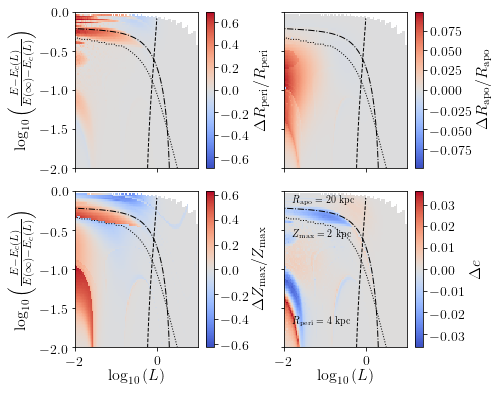

In [41]:
legrid = np.mgrid[-2.:0.:101j,-2:1.:101j]

extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = (par_int[:,:,i]-par_estd[:,:,i])/par_int[:,:,i]
    else:
        de = par_int[:,:,i]-par_estd[:,:,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_divergent.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_divergent.png', format='png', dpi=400)

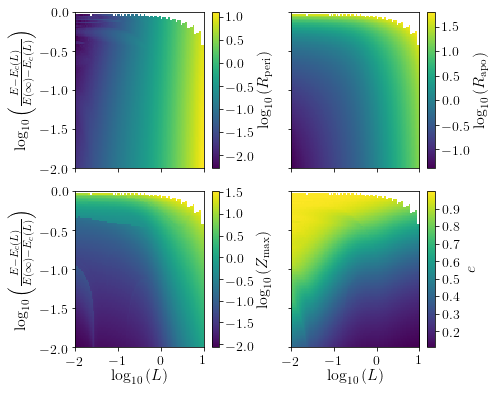

In [5]:
extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\log_{10}{(R_{\mathrm{peri}})}$',r'$\log_{10}{(R_{\mathrm{apo}})}$',r'$\log_{10}{(Z_{\mathrm{max}})}$',r'$e$']
for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = np.log10(par_int[:,:,i])
    else:
        de = par_int[:,:,i]
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.viridis, extent=extent, aspect='auto')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])


ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()
plt.savefig('../plots/orbit_params_integration.pdf', format='pdf')
plt.savefig('../plots/orbit_params_integration.png', format='png', dpi=400)

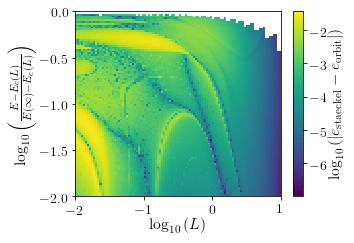

In [6]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.imshow(np.log10(np.rot90(np.fabs(par_estd[:,:,3]-par_int[:,:,3]))), cmap=plt.cm.viridis, extent=extent, aspect='auto')
plt.xlabel(r'$\log_{10}{(L)}$')
plt.ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.colorbar(label=r'$\log_{10}{\left(|e_{\mathrm{staeckel}}-e_{\mathrm{orbit}}|\right)}$', ticks=[-7,-6,-5,-4,-3,-2,-1,0])
fig.tight_layout()

fig.savefig('../plots/orbit_param_comparison_abs.pdf', format='pdf')
fig.savefig('../plots/orbit_param_comparison_abs.png', format='png', dpi=400)

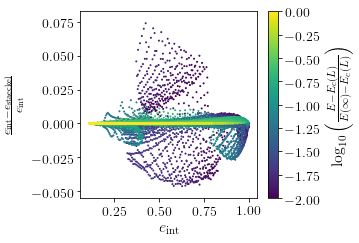

In [15]:
legrid = np.mgrid[-2.:0.:101j,0.01:10.:101j]


fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), (par_int[:,:,3]-par_estd[:,:,3]).ravel()/par_int[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_energy.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_energy.png', format='png', dpi=400)

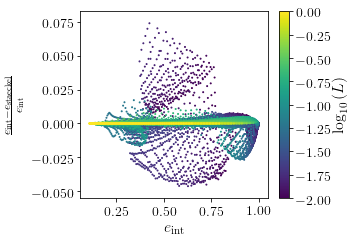

In [16]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), ((par_int[:,:,3]-par_estd[:,:,3])/par_int[:,:,3]).ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(L\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_L.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_L.png', format='png', dpi=400)

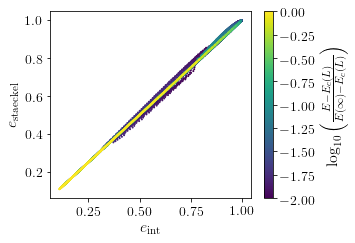

In [17]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), par_estd[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$e_{\mathrm{staeckel}}$')
fig.tight_layout()

In [18]:
print np.nanstd((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())
print np.nanmean((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())

0.00929311109918
0.000636273230205


(-3.0, 3)

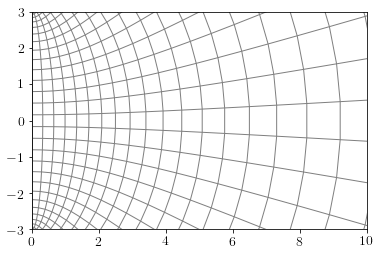

In [19]:
uv_grid = np.mgrid[0.:np.pi:30j, 0.:np.pi:30j]
delta = 0.375
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])*8
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])*8
plt.plot(R, Z, color='Gray')
plt.plot(R.T, Z.T, color='Gray')

plt.xlim(0.,10.)
plt.ylim(-3.,3)
